# Tarea 3 - Big Data
Estudiante: Steven Jimenez



# Datos de entrada

## Dataset: Calidad del Vino

El archivo winequality-red.csv contiene métricas sobre la calidad de Vinos Rojos. La intención con este dataset es predecir si un vino es de Alta Calidad o Baja Calidad, basado en el análisis de distintos features. Explícitamente:

### Features
* "fixed_acidity": la mayoría de los ácidos involucrados con el vino o fijos o no volátiles (no se evaporan fácilmente)
* "volatile_acidity":la cantidad de ácido acético en el vino, que en niveles demasiado altos puede provocar un sabor desagradable a vinagre
* "citric_acid":Encontrado en pequeñas cantidades, el ácido cítrico puede agregar 'frescura' y sabor a los vinos.
* "residual_sugar": la cantidad de azúcar que queda después de que se detiene la fermentación, es raro encontrar vinos con menos de 1 gramo / litro y los vinos con más de 45 gramos / litro se consideran dulces
* "chlorides": la cantidad de sal en el vino
* "free_sulfur_dioxide": la forma libre del SO2 existe en equilibrio entre el SO2 molecular (como gas disuelto) y el ion bisulfito; Previene el crecimiento microbiano y la oxidación del vino.
* "total_sulfur_dioxide":cantidad de formas libres y ligadas de SO2; en bajas concentraciones, el SO2 es mayormente indetectable en el vino, pero en concentraciones de SO2 libre superiores a 50 ppm, el SO2 se hace evidente en la nariz y el sabor del vino.
* "density": la densidad del agua es cercana a la del agua dependiendo del porcentaje de alcohol y contenido de azúcar
* "pH": describe qué tan ácido o básico es un vino en una escala de 0 (muy ácido) a 14 (muy básico); la mayoría de los vinos están entre 3-4 en la escala de pH
* "sulphates": un aditivo para el vino que puede contribuir a los niveles de dióxido de azufre (SO2), que actúa como antimicrobiano y antioxidante
* "alcohol":  el porcentaje de contenido de alcohol del vino
* "quality": variable de salida (basada en datos sensoriales, puntuación entre 0 y 10)





### Variable de predicción (Variable sintetica)
Variable sintética, creada para cumplir el requisito de que sea un problema de clasificación binaria. 
* BinaryQuality: Si el parámetro "quality" es mayor a 5, se catalogará al vino como 1 (Refiriendose a Vino de Alta Calidad), de lo contrario se catalogará como 0 (Refiriendose a Vino de Baja Calidad)





Dataset source:https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009

#  Preprocesamiento de datos 


## Carga/lectura de datos (.csv) Limpieza

Definición del "schema" y lectura del archivo .csv

In [30]:
# Cargar el conjunto de datos completo. Este paso no realiza ningún ajuste; simplemente lectura
import findspark
from pyspark.sql.functions import isnan, when, count, col
import pandas as pd
findspark.init('/usr/lib/python3.7/site-packages/pyspark')

from pyspark.sql.types import (StringType, IntegerType, FloatType, 
                               DecimalType, StructField, StructType)

from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Basic JDBC pipeline") \
    .config("spark.driver.extraClassPath", "postgresql-42.2.14.jar") \
    .config("spark.executor.extraClassPath", "postgresql-42.2.14.jar") \
    .getOrCreate()

RawWine_df = spark \
    .read \
    .format("csv") \
    .option("path", "winequality-red.csv") \
    .option("header", True) \
    .schema(StructType([
                StructField("fixed_acidity",FloatType()),
                StructField("volatile_acidity",FloatType()),
                StructField("citric_acid",FloatType()),
                StructField("residual_sugar",FloatType()),
                StructField("chlorides",FloatType()),
                StructField("free_sulfur_dioxide",FloatType()),
                StructField("total_sulfur_dioxide",FloatType()),
                StructField("density",FloatType()),
                StructField("pH",FloatType()),
                StructField("sulphates",FloatType()),
                StructField("alcohol",FloatType()),                
                StructField("quality",IntegerType())])) \
    .load()
print('Qty Filas: {}\n Cantidad Columnas: {}'.format(RawWine_df.count(), len(RawWine_df.columns)))
RawWine_df.printSchema()
RawWine_df.show(truncate=False,n=3)

Qty Filas: 1599
 Cantidad Columnas: 12
root
 |-- fixed_acidity: float (nullable = true)
 |-- volatile_acidity: float (nullable = true)
 |-- citric_acid: float (nullable = true)
 |-- residual_sugar: float (nullable = true)
 |-- chlorides: float (nullable = true)
 |-- free_sulfur_dioxide: float (nullable = true)
 |-- total_sulfur_dioxide: float (nullable = true)
 |-- density: float (nullable = true)
 |-- pH: float (nullable = true)
 |-- sulphates: float (nullable = true)
 |-- alcohol: float (nullable = true)
 |-- quality: integer (nullable = true)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|free_sulfur_dioxide|total_sulfur_dioxide|density|pH  |sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+------

21/11/04 04:14:58 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol, quality
 Schema: fixed_acidity, volatile_acidity, citric_acid, residual_sugar, chlorides, free_sulfur_dioxide, total_sulfur_dioxide, density, pH, sulphates, alcohol, quality
Expected: fixed_acidity but found: fixed acidity
CSV file: file:///src/tarea3Jupyter/winequality-red.csv


### Creación de variable sintética - 'BinaryQuality'

In [31]:
from pyspark.sql import functions as F
threshold = 5
WineQualityDF = RawWine_df.withColumn('BinaryQuality', F.when(F.col("quality") <= threshold, 0)\
                                                        .when(F.col("quality") > threshold, 1))
WineQualityDF.show(n=5)


+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-------------+
|fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|free_sulfur_dioxide|total_sulfur_dioxide|density|  pH|sulphates|alcohol|quality|BinaryQuality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-------------+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|      5|            0|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|      5|            0|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|      5|            0|
|         11.2| 

21/11/04 04:14:58 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol, quality
 Schema: fixed_acidity, volatile_acidity, citric_acid, residual_sugar, chlorides, free_sulfur_dioxide, total_sulfur_dioxide, density, pH, sulphates, alcohol, quality
Expected: fixed_acidity but found: fixed acidity
CSV file: file:///src/tarea3Jupyter/winequality-red.csv


En el siguiente paso eliminamos la variable Quality para realizar el proceso de clasificación en base a nuestra vartiable sintética llamada "BinaryQuality"

In [32]:
WineQualityDF = WineQualityDF.drop("quality")
WineQualityDF.show(n=5)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------------+
|fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|free_sulfur_dioxide|total_sulfur_dioxide|density|  pH|sulphates|alcohol|BinaryQuality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------------+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|            0|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|            0|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|            0|
|         11.2|            0.28|       0.56|           1.9|    0

21/11/04 04:14:58 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol, quality
 Schema: fixed_acidity, volatile_acidity, citric_acid, residual_sugar, chlorides, free_sulfur_dioxide, total_sulfur_dioxide, density, pH, sulphates, alcohol, quality
Expected: fixed_acidity but found: fixed acidity
CSV file: file:///src/tarea3Jupyter/winequality-red.csv


## Limpieza de datos

**Busquedas de valores "NaN": Not a Number**: No se identifican valores NaN

In [33]:
WineQualityDF.select([count(when(isnan(c), c)).alias(c) for c in WineQualityDF.columns]).show()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------------+
|fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|free_sulfur_dioxide|total_sulfur_dioxide|density| pH|sulphates|alcohol|BinaryQuality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------------+
|            0|               0|          0|             0|        0|                  0|                   0|      0|  0|        0|      0|            0|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------------+



21/11/04 04:14:59 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol, quality
 Schema: fixed_acidity, volatile_acidity, citric_acid, residual_sugar, chlorides, free_sulfur_dioxide, total_sulfur_dioxide, density, pH, sulphates, alcohol, quality
Expected: fixed_acidity but found: fixed acidity
CSV file: file:///src/tarea3Jupyter/winequality-red.csv


**Busqueda de valores "Null"**: Se identifican varios valores Null

In [34]:
WineQualityDF.select([count(when(col(c).isNull(), c)).alias(c) for c in WineQualityDF.columns]).show()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------------+
|fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|free_sulfur_dioxide|total_sulfur_dioxide|density| pH|sulphates|alcohol|BinaryQuality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------------+
|            0|               0|          0|             0|        0|                  0|                   0|      0|  0|        0|      0|            0|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------------+



21/11/04 04:14:59 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol, quality
 Schema: fixed_acidity, volatile_acidity, citric_acid, residual_sugar, chlorides, free_sulfur_dioxide, total_sulfur_dioxide, density, pH, sulphates, alcohol, quality
Expected: fixed_acidity but found: fixed acidity
CSV file: file:///src/tarea3Jupyter/winequality-red.csv


No se encontraron datos NaN, tampoco Nulls, por lo que no fue necesario limpiar los datos. (Para términos de este ejercicio omitiremos la presencia de outliers, puesto que no tengo el conocimiento técnico para mantener/descartar en caso de que existiera un outlier)

## Gráficos y estadísdisticas descriptivas

**Estadísticas descriptivas - Features y Variable a predecir**

In [35]:
WineQualityDF.describe(WineQualityDF.schema.names[0:4]).show()

+-------+------------------+-------------------+-------------------+------------------+
|summary|     fixed_acidity|   volatile_acidity|        citric_acid|    residual_sugar|
+-------+------------------+-------------------+-------------------+------------------+
|  count|              1599|               1599|               1599|              1599|
|   mean|  8.31963727204333| 0.5278205118742565|0.27097560946082344|2.5388054955072743|
| stddev|1.7410963179910275|0.17905970357107073|0.19480113735645493|1.4099280590834145|
|    min|               4.6|               0.12|                0.0|               0.9|
|    max|              15.9|               1.58|                1.0|              15.5|
+-------+------------------+-------------------+-------------------+------------------+



21/11/04 04:14:59 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: fixed acidity, volatile acidity, citric acid, residual sugar
 Schema: fixed_acidity, volatile_acidity, citric_acid, residual_sugar
Expected: fixed_acidity but found: fixed acidity
CSV file: file:///src/tarea3Jupyter/winequality-red.csv


In [36]:
WineQualityDF.describe(WineQualityDF.schema.names[4:8]).show()

21/11/04 04:14:59 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: chlorides, free sulfur dioxide, total sulfur dioxide, density
 Schema: chlorides, free_sulfur_dioxide, total_sulfur_dioxide, density
Expected: free_sulfur_dioxide but found: free sulfur dioxide
CSV file: file:///src/tarea3Jupyter/winequality-red.csv


+-------+-------------------+-------------------+--------------------+--------------------+
|summary|          chlorides|free_sulfur_dioxide|total_sulfur_dioxide|             density|
+-------+-------------------+-------------------+--------------------+--------------------+
|  count|               1599|               1599|                1599|                1599|
|   mean|0.08746654185244558| 15.874921826141339|   46.46779237023139|  0.9967466800044371|
| stddev|0.04706530186883863|  10.46015696980971|   32.89532447829907|0.001887335252223...|
|    min|              0.012|                1.0|                 6.0|             0.99007|
|    max|              0.611|               72.0|               289.0|             1.00369|
+-------+-------------------+-------------------+--------------------+--------------------+



In [37]:
WineQualityDF.describe(WineQualityDF.schema.names[8:11]).show()

+-------+-------------------+-------------------+------------------+
|summary|                 pH|          sulphates|           alcohol|
+-------+-------------------+-------------------+------------------+
|  count|               1599|               1599|              1599|
|   mean| 3.3111131965107585| 0.6581488421292809|10.422983095003262|
| stddev|0.15438646318792024|0.16950698014899196|1.0656675859276652|
|    min|               2.74|               0.33|               8.4|
|    max|               4.01|                2.0|              14.9|
+-------+-------------------+-------------------+------------------+



In [38]:
WineQualityDF.groupBy("BinaryQuality").count().show(truncate=False)

+-------------+-----+
|BinaryQuality|count|
+-------------+-----+
|1            |855  |
|0            |744  |
+-------------+-----+



**Matriz correlación Pearson y Vectorización**

In [39]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=WineQualityDF.drop("BinaryQuality").schema.names,
    outputCol='features')

vector_df = assembler.transform(WineQualityDF)
vector_df = vector_df.select(['features', "BinaryQuality"])
vector_df.show(n=15)

+--------------------+-------------+
|            features|BinaryQuality|
+--------------------+-------------+
|[7.40000009536743...|            0|
|[7.80000019073486...|            0|
|[7.80000019073486...|            0|
|[11.1999998092651...|            1|
|[7.40000009536743...|            0|
|[7.40000009536743...|            0|
|[7.90000009536743...|            0|
|[7.30000019073486...|            1|
|[7.80000019073486...|            1|
|[7.5,0.5,0.360000...|            0|
|[6.69999980926513...|            0|
|[7.5,0.5,0.360000...|            0|
|[5.59999990463256...|            0|
|[7.80000019073486...|            0|
|[8.89999961853027...|            0|
+--------------------+-------------+
only showing top 15 rows



21/11/04 04:15:00 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol, quality
 Schema: fixed_acidity, volatile_acidity, citric_acid, residual_sugar, chlorides, free_sulfur_dioxide, total_sulfur_dioxide, density, pH, sulphates, alcohol, quality
Expected: fixed_acidity but found: fixed acidity
CSV file: file:///src/tarea3Jupyter/winequality-red.csv


21/11/04 04:15:00 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol
 Schema: fixed_acidity, volatile_acidity, citric_acid, residual_sugar, chlorides, free_sulfur_dioxide, total_sulfur_dioxide, density, pH, sulphates, alcohol
Expected: fixed_acidity but found: fixed acidity
CSV file: file:///src/tarea3Jupyter/winequality-red.csv
21/11/04 04:15:00 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol
 Schema: fixed_acidity, volatile_acidity, citric_acid, residual_sugar, chlorides, free_sulfur_dioxide, total_sulfur_dioxide, density, pH, sulphates, alcohol
Expected: fixed_acidity but found: fixed acidity
CSV file: file:///src/tarea3Jupyter/winequality-re

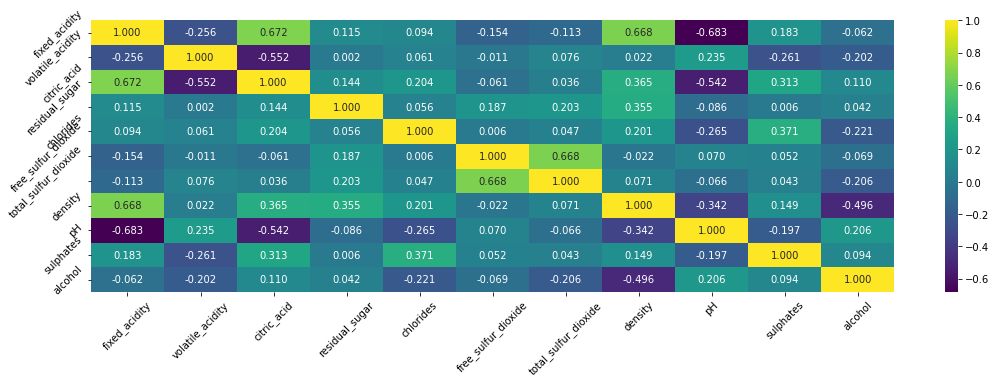

In [40]:
from pyspark.ml.stat import Correlation
import seaborn as sns
import matplotlib.pyplot as plt

pearson_matrix = Correlation.corr(vector_df, 'features').collect()[0][0]
fig, ax = plt.subplots(figsize=(18,5))  
sns.heatmap(pearson_matrix.toArray(), annot=True, fmt=".3f", cmap='viridis', ax=ax)
ax.set_xticklabels(WineQualityDF.drop("BinaryQuality").schema.names)
ax.set_yticklabels(WineQualityDF.drop("BinaryQuality").schema.names)
ax.tick_params(labelrotation=45)



De esta matriz se observa que si existe variable con una fuerte correlación tanto positiva ("Density" vs "free_sulfur_dioxide") y como correlación negativa ("pH" vs "fixed_acidity")

## Normalización de Datos
Se utilizó el método de normalización por la siguientes razones:
* Para un conjunto de datos con múltiples Features que abarcan diversos grados de magnitud, rango y unidades, el método de normalización "mapea" los features a distancias ahora son más comparables de lo que eran antes de que se aplicara la normalización.
* La estandarización no tiene un rango límite, por lo que si el dataset tiene valores atípicos en sus datos, no se verán afectados por la estandarización.


In [41]:
from pyspark.ml.feature import StandardScaler

standard_scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')
scale_model = standard_scaler.fit(vector_df)

scaled_df = scale_model.transform(vector_df)
scaled_df.show()

+--------------------+-------------+--------------------+
|            features|BinaryQuality|      scaledFeatures|
+--------------------+-------------+--------------------+
|[7.40000009536743...|            0|[4.25019570652240...|
|[7.80000019073486...|            0|[4.47993606679665...|
|[7.80000019073486...|            0|[4.47993606679665...|
|[11.1999998092651...|            1|[6.43272844444832...|
|[7.40000009536743...|            0|[4.25019570652240...|
|[7.40000009536743...|            0|[4.25019570652240...|
|[7.90000009536743...|            0|[4.53737108839727...|
|[7.30000019073486...|            1|[4.19276068492178...|
|[7.80000019073486...|            1|[4.47993606679665...|
|[7.5,0.5,0.360000...|            0|[4.30763072812302...|
|[6.69999980926513...|            0|[3.84815000757451...|
|[7.5,0.5,0.360000...|            0|[4.30763072812302...|
|[5.59999990463256...|            0|[3.21636422222416...|
|[7.80000019073486...|            0|[4.47993606679665...|
|[8.8999996185

21/11/04 04:15:01 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol
 Schema: fixed_acidity, volatile_acidity, citric_acid, residual_sugar, chlorides, free_sulfur_dioxide, total_sulfur_dioxide, density, pH, sulphates, alcohol
Expected: fixed_acidity but found: fixed acidity
CSV file: file:///src/tarea3Jupyter/winequality-red.csv
21/11/04 04:15:01 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol, quality
 Schema: fixed_acidity, volatile_acidity, citric_acid, residual_sugar, chlorides, free_sulfur_dioxide, total_sulfur_dioxide, density, pH, sulphates, alcohol, quality
Expected: fixed_acidity but found: fixed acidity
CSV file: file:///src/tarea3Jupy

In [42]:
cleaned_df = scaled_df.select("scaledFeatures","BinaryQuality")
cleaned_df.show(truncate = False)
cleaned_df.printSchema()

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+
|scaledFeatures                                                                                                                                                                                                |BinaryQuality|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+
|[4.250195706522404,3.909310549043959,0.0,1.3475864700453726,1.6147776501679734,1.0516094578454602,1.033581535954439,528.681902902932,22.735153833991657,3.3036987733010235,8.820761504486935]                 |0            |
|[4.479936066796656,4.914561890148259,0.0,1.84406565135161,2.082213298240522,2.3900214951033187,2.0367636149

21/11/04 04:15:01 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol, quality
 Schema: fixed_acidity, volatile_acidity, citric_acid, residual_sugar, chlorides, free_sulfur_dioxide, total_sulfur_dioxide, density, pH, sulphates, alcohol, quality
Expected: fixed_acidity but found: fixed acidity
CSV file: file:///src/tarea3Jupyter/winequality-red.csv


## Escritura a la base de datos

Regeneramos los nombres de las columnas de cada feature del dataset para escribir a la base de datos

In [43]:
from pyspark.ml.functions import vector_to_array

features_col_names = WineQualityDF.drop("BinaryQuality").schema.names


ExpandedDFtoDB = (cleaned_df.withColumn("xs", vector_to_array("scaledFeatures")))\
    .select([col("xs")[i].alias(features_col_names[i]) for i in range(11)]+["BinaryQuality"])


ExpandedDFtoDB.show()

+------------------+------------------+-------------------+------------------+------------------+-------------------+--------------------+-----------------+------------------+------------------+-----------------+-------------+
|     fixed_acidity|  volatile_acidity|        citric_acid|    residual_sugar|         chlorides|free_sulfur_dioxide|total_sulfur_dioxide|          density|                pH|         sulphates|          alcohol|BinaryQuality|
+------------------+------------------+-------------------+------------------+------------------+-------------------+--------------------+-----------------+------------------+------------------+-----------------+-------------+
| 4.250195706522404| 3.909310549043959|                0.0|1.3475864700453726|1.6147776501679734| 1.0516094578454602|   1.033581535954439| 528.681902902932|22.735153833991657|3.3036987733010235|8.820761504486935|            0|
| 4.479936066796656| 4.914561890148259|                0.0|  1.84406565135161| 2.08221329824

21/11/04 04:15:01 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol, quality
 Schema: fixed_acidity, volatile_acidity, citric_acid, residual_sugar, chlorides, free_sulfur_dioxide, total_sulfur_dioxide, density, pH, sulphates, alcohol, quality
Expected: fixed_acidity but found: fixed acidity
CSV file: file:///src/tarea3Jupyter/winequality-red.csv


Escribimos con overwrite la tabla **tarea3** a la base de datos

In [44]:
# Almacenar el conjunto de datos limpio en la base de datos
ExpandedDFtoDB \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "tarea3") \
    .save()

21/11/04 04:15:01 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol, quality
 Schema: fixed_acidity, volatile_acidity, citric_acid, residual_sugar, chlorides, free_sulfur_dioxide, total_sulfur_dioxide, density, pH, sulphates, alcohol, quality
Expected: fixed_acidity but found: fixed acidity
CSV file: file:///src/tarea3Jupyter/winequality-red.csv


# Entrenamiento de modelos

## Lectura desde la base de datos


Leemos la tabla **tarea3** desde la base de datos

In [45]:
# Cargar el conjunto de datos. Esta vez desde la base de datos

# Reading single DataFrame in Spark by retrieving all rows from a DB table.
df = spark \
    .read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "tarea3") \
    .load()

df.show(n=3)

+-----------------+-----------------+------------------+------------------+------------------+-------------------+--------------------+-----------------+------------------+------------------+-----------------+-------------+
|    fixed_acidity| volatile_acidity|       citric_acid|    residual_sugar|         chlorides|free_sulfur_dioxide|total_sulfur_dioxide|          density|                pH|         sulphates|          alcohol|BinaryQuality|
+-----------------+-----------------+------------------+------------------+------------------+-------------------+--------------------+-----------------+------------------+------------------+-----------------+-------------+
|4.250195706522404|3.909310549043959|               0.0|1.3475864700453726|1.6147776501679734| 1.0516094578454602|   1.033581535954439| 528.681902902932|22.735153833991657|3.3036987733010235|8.820761504486935|            0|
|4.479936066796656|4.914561890148259|               0.0|  1.84406565135161| 2.082213298240522| 2.3900214

Vectorizamos los features para poder utilizar las funciones de Machine Learning de Spark (spark.ML)

In [46]:
# Para realizar operaciones más detalladas es necesario expresar las filas originales en vectores
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=WineQualityDF.drop("BinaryQuality").schema.names,
    outputCol='features')

vector_df = assembler.transform(df)
vector_df = vector_df.select(['features', "BinaryQuality"])
vector_df.printSchema()
vector_df.show(n=3)



root
 |-- features: vector (nullable = true)
 |-- BinaryQuality: integer (nullable = true)

+--------------------+-------------+
|            features|BinaryQuality|
+--------------------+-------------+
|[4.25019570652240...|            0|
|[4.47993606679665...|            0|
|[4.47993606679665...|            0|
+--------------------+-------------+
only showing top 3 rows



# Entrenamiento de modelos


Dividimos el dataset en Training (90%) y Testing (10%). Se utiliza esta partición para de 90% para training con el objetivo de aplicar el protocolo de validación K Fold. Se utiliza el 10% restante para validar el modelo

In [47]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

# Prepare train/test and validation data.

print("*****************************")
trainDF, testDF = vector_df.randomSplit([0.9,0.1], seed = 21)
print('trainDF--> Qty Filas: {}  Cantidad Columnas: {}'.format(trainDF.count(), len(trainDF.columns)))
print('testDF--> Filas: {}  Cantidad Columnas: {}'.format(testDF.count(), len(testDF.columns)))
print("*****************************")

*****************************
trainDF--> Qty Filas: 1437  Cantidad Columnas: 2
testDF--> Filas: 162  Cantidad Columnas: 2
*****************************


## Clasificador - Arbol de Decision

El siguiente modelo utiliza el protocolo de validación K-Fold, además que se logra un entrenamiento entrenar un modelo predictivo

In [48]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
#from mmlspark import ComputeModelStatistics

# Crear el model inicial de arbol de decision
dt = DecisionTreeClassifier(labelCol="BinaryQuality", featuresCol="features", maxDepth=8)

# crear grilla para probar el modelo 
dtparamGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [4])             
             .build())

# Evaluar el modelo
dtevaluator = BinaryClassificationEvaluator()
dtevaluator.setRawPredictionCol("prediction")
dtevaluator.setLabelCol("BinaryQuality")


# Create 5-fold CrossValidator
dtcv = CrossValidator(estimator = dt, estimatorParamMaps = dtparamGrid,evaluator = dtevaluator,numFolds = 5)#

# Run cross validations
dtcvModel = dtcv.fit(trainDF)
predictions = dtcvModel.transform(testDF)

print(dtcvModel)

print("****Evaluar Underfitting / Overfitting del modelo****")
print("dtpredictionsTrain")
dtpredictionsTrain = dtcvModel.transform(trainDF)
print("areaUnderROC Train",dtevaluator.evaluate(dtpredictionsTrain, {dtevaluator.metricName: "areaUnderROC"}))
print("******************************************************")
print("dtpredictionsTest")
dtpredictionsTest = dtcvModel.transform(testDF)
print("areaUnderROC Test",dtevaluator.evaluate(dtpredictionsTest, {dtevaluator.metricName: "areaUnderROC"}))
print("******************************************************")


predictionsDF1 = dtpredictionsTest

CrossValidatorModel_6323644056fd
****Evaluar Underfitting / Overfitting del modelo****
dtpredictionsTrain
areaUnderROC Train 0.7556208527116699
******************************************************
dtpredictionsTest
areaUnderROC Test 0.6858108108108107
******************************************************


Se observa que el modelo se entrenó de manera correcta puesto que los valores de areaUnderROC para Training y Validación son muy cercanos, lo cual significa que no hubo overfitting ni underfitting. 

Escritura de la tabla **modelo1** a la base de datos

In [49]:
from pyspark.ml.functions import vector_to_array

features_col_names = WineQualityDF.drop("BinaryQuality").schema.names
print(features_col_names)


ExpandedDFtoDB = (predictionsDF1.drop("rawPrediction","probability").withColumn("xs", vector_to_array("features")))\
    .select([col("xs")[i].alias(features_col_names[i]) for i in range(11)]+["BinaryQuality"]+["prediction"])


ExpandedDFtoDB.show(n=3)

# Almacenar el conjunto de datos limpio en la base de datos
ExpandedDFtoDB \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "modelo1") \
    .save()

['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol']
+------------------+-----------------+------------------+------------------+------------------+-------------------+--------------------+-----------------+-----------------+------------------+------------------+-------------+----------+
|     fixed_acidity| volatile_acidity|       citric_acid|    residual_sugar|         chlorides|free_sulfur_dioxide|total_sulfur_dioxide|          density|               pH|         sulphates|           alcohol|BinaryQuality|prediction|
+------------------+-----------------+------------------+------------------+------------------+-------------------+--------------------+-----------------+-----------------+------------------+------------------+-------------+----------+
|3.2163642222241644|3.685921584049102|               0.0|  1.77314011441494|1.4023069442176455| 0.6692060186289293| 0.45

## Clasificador - LogisticRegression

El siguiente model utilizar el protocolo de validación K-Fold, además que se logra un entrenamiento entrenar un modelo predictivo

In [50]:
#https://gist.github.com/colbyford/7758088502211daa90dbc1b51c408762 

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
#from mmlspark import ComputeModelStatistics

# Crear el model inicial de regresion logistiva
lr = LogisticRegression(labelCol="BinaryQuality", featuresCol="features")
# crear grilla para probar el modelo 
lrparamGrid = (ParamGridBuilder()
             .addGrid(lr.maxIter, [15])             
             .build())

# Evaluar el model
dtevaluator = BinaryClassificationEvaluator()
dtevaluator.setRawPredictionCol("prediction")
dtevaluator.setLabelCol("BinaryQuality")


# Create 5-fold CrossValidator
dtcv = CrossValidator(estimator = lr, estimatorParamMaps = lrparamGrid,evaluator = dtevaluator,numFolds = 5)#

# Run cross validations
dtcvModel = dtcv.fit(trainDF)
predictions = dtcvModel.transform(testDF)

print(dtcvModel)

print("****Evaluar Underfitting / Overfitting del modelo****")
print("dtpredictionsTrain")
dtpredictionsTrain = dtcvModel.transform(trainDF)
print("areaUnderROC Train",dtevaluator.evaluate(dtpredictionsTrain, {dtevaluator.metricName: "areaUnderROC"}))
print("******************************************************")

print("dtpredictionsTest")
dtpredictionsTest = dtcvModel.transform(testDF)
print("areaUnderROC Test",dtevaluator.evaluate(dtpredictionsTest, {dtevaluator.metricName: "areaUnderROC"}))
print("******************************************************")


predictionsDF2 = dtpredictionsTest


CrossValidatorModel_e9bad1850e50
****Evaluar Underfitting / Overfitting del modelo****
dtpredictionsTrain
areaUnderROC Train 0.7449775243729204
******************************************************
dtpredictionsTest
areaUnderROC Test 0.7249692874692876
******************************************************


Se observa que el modelo se entrenó de manera correcta puesto que los valores de areaUnderROC para Training y Validación son muy cercanos, lo cual significa que no hubo overfitting ni underfitting. 

Escritura de la tabla **modelo2** a la base de datos

In [51]:
from pyspark.ml.functions import vector_to_array

features_col_names = WineQualityDF.drop("BinaryQuality").schema.names
print(features_col_names)


ExpandedDFtoDB = (predictionsDF2.drop("rawPrediction","probability").withColumn("xs", vector_to_array("features")))\
    .select([col("xs")[i].alias(features_col_names[i]) for i in range(11)]+["BinaryQuality"]+["prediction"])


ExpandedDFtoDB.show(n=3)

# Almacenar el conjunto de datos limpio en la base de datos
ExpandedDFtoDB \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "modelo2") \
    .save()

['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol']
+------------------+-----------------+------------------+------------------+------------------+-------------------+--------------------+-----------------+-----------------+------------------+------------------+-------------+----------+
|     fixed_acidity| volatile_acidity|       citric_acid|    residual_sugar|         chlorides|free_sulfur_dioxide|total_sulfur_dioxide|          density|               pH|         sulphates|           alcohol|BinaryQuality|prediction|
+------------------+-----------------+------------------+------------------+------------------+-------------------+--------------------+-----------------+-----------------+------------------+------------------+-------------+----------+
|3.2163642222241644|3.685921584049102|               0.0|  1.77314011441494|1.4023069442176455| 0.6692060186289293| 0.45

### Análisis de resultados

Basado en la matriz de decisión generada en las siguientes secciones de código se observa que el modelo de Regresión logística tiene más Falsos negativos en comparación con el modelo de arbol de decisión. Ambos modelos tiene una taza de acierto similar.  

**Matriz de confusión Arbol de decisión**

No handles with labels found to put in legend.


size 162


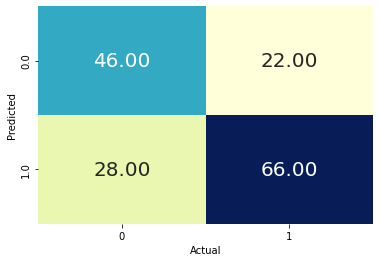

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
pandasDF1 = predictionsDF1.drop("features","rawPrediction","probability").toPandas()
pandasDF1.head()
print("size" ,len(pandasDF1.index))

y_true = pandasDF1["BinaryQuality"]
y_pred = pandasDF1["prediction"]


confusion_matrix = pd.crosstab(y_true, y_pred, rownames=['Actual'], colnames=['Predicted'])

plt.clf()

ax = fig.add_subplot(111)

ax.set_aspect(1)

res = sn.heatmap(confusion_matrix.T, annot=True, fmt='.2f', cmap="YlGnBu", cbar=False,annot_kws={"fontsize":20})
ax.legend( fontsize=20)



plt.show()

**Matriz de confusión Regresión logística**

No handles with labels found to put in legend.


size 162


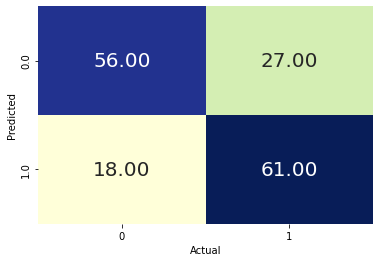

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
pandasDF2 = predictionsDF2.drop("features","rawPrediction","probability").toPandas()
pandasDF2.head()
print("size" ,len(pandasDF1.index))

y_true = pandasDF2["BinaryQuality"]
y_pred = pandasDF2["prediction"]


confusion_matrix = pd.crosstab(y_true, y_pred, rownames=['Actual'], colnames=['Predicted'])

plt.clf()

ax = fig.add_subplot(111)

ax.set_aspect(1)

res = sn.heatmap(confusion_matrix.T, annot=True, fmt='.2f', cmap="YlGnBu", cbar=False,annot_kws={"fontsize":20})
ax.legend( fontsize=20)



plt.show()